<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/CalcSynergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library 



In [ ]:
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! conda config --set always_yes yes --set changeps1 no
! conda install -q -y -c conda-forge python=3.7
! conda install -q -y -c conda-forge rdkit==2020.09.2 

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [ ]:
! pip install keras
! pip install tensorflow
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install deepchem
! pip install pubchempy
! pip install stringdb

In [39]:
#import deepchem as dc
import stringdb
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
#import deepchem as dc
#from rdkit import Chem
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
import numpy as np
import urllib
import pubchempy as pcp
import random 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)
import matplotlib.pyplot as plt
import seaborn as sns


In [299]:
def keymap_replace(
        string: str, 
        mappings: dict,
        *,
        lower_keys=False,
        lower_values=False,
        lower_string=False,
    ) -> str:
    """Replace parts of a string based on a dictionary.

    This function takes a string a dictionary of
    replacement mappings. For example, if I supplied
    the string "Hello world.", and the mappings 
    {"H": "J", ".": "!"}, it would return "Jello world!".

    Keyword arguments:
    string       -- The string to replace characters in.
    mappings     -- A dictionary of replacement mappings.
    lower_keys   -- Whether or not to lower the keys in mappings.
    lower_values -- Whether or not to lower the values in mappings.
    lower_string -- Whether or not to lower the input string.
    """
    replaced_string = string.lower() if lower_string else string
    for character, replacement in mappings.items():
        replaced_string = replaced_string.replace(
            character.lower() if lower_keys else character,
            replacement.lower() if lower_values else replacement
        )
    return replaced_string

#Synergy Data Exploration

In [41]:
sample_info = {}
sample_data_explore = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/data/sample.txt",sep="\t")
sample_info["Unique_drugComb_number"] = sample_data_explore.groupby(['drug_row','drug_col']).count().reset_index().shape[0]
drug_row_count = sample_data_explore.iloc[:,1].unique()
drug_col_count = sample_data_explore.iloc[:,2].unique()
all_sample_count = np.unique(np.concatenate((drug_row_count,drug_col_count))).__len__()
all_sample = np.unique(np.concatenate((drug_row_count,drug_col_count)))

sample_info["singel_drug_number"] = all_sample.__len__()
sample_info["cell_line_number"] = 11
sample_info

{'Unique_drugComb_number': 5852,
 'cell_line_number': 11,
 'singel_drug_number': 127}

In [42]:
sample_data = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/data/sample.txt",sep="\t")
sample_data_02 = sample_data[["drug_row","drug_col","synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa","cell_line_name"]]
sample_data_03 = sample_data_02.groupby(['drug_row','drug_col','cell_line_name']).agg({'synergy_loewe': 'mean',
                                                                                       'synergy_zip': 'mean',
                                                                                       'synergy_bliss': 'mean',
                                                                                       'synergy_hsa': 'mean'}).reset_index()

sample_data_03["cell_line_name"].value_counts().to_dict()

{'BT-549': 5213,
 'EFM192B': 583,
 'HS 578T': 5188,
 'KPL1': 583,
 'MCF7': 5271,
 'MDA-MB-231': 5263,
 'MDA-MB-468': 5203,
 'MDAMB436': 583,
 'OCUBM': 583,
 'T-47D': 5733,
 'ZR751': 583}

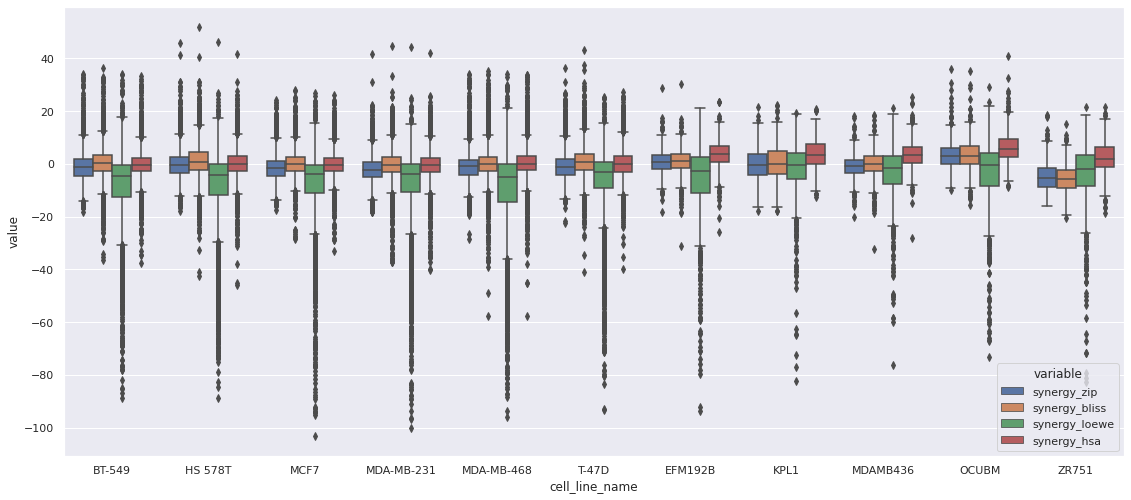

In [43]:
melt_df = pd.melt(sample_data_03.iloc[:,2:], id_vars =['cell_line_name'], value_vars =["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa"])
sns.set(rc={'figure.figsize':(19,8.27)})
sns.boxplot(x="cell_line_name", y="value",
            hue="variable",
            data=melt_df)

In [44]:
sample_data_03[["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa","cell_line_name"]].corr()

,synergy_zip,synergy_bliss,synergy_loewe,synergy_hsa
synergy_zip,1.000000,0.780337,0.156517,0.525530
synergy_bliss,0.780337,1.000000,0.274733,0.773432
synergy_loewe,0.156517,0.274733,1.000000,0.415250
synergy_hsa,0.525530,0.773432,0.415250,1.000000


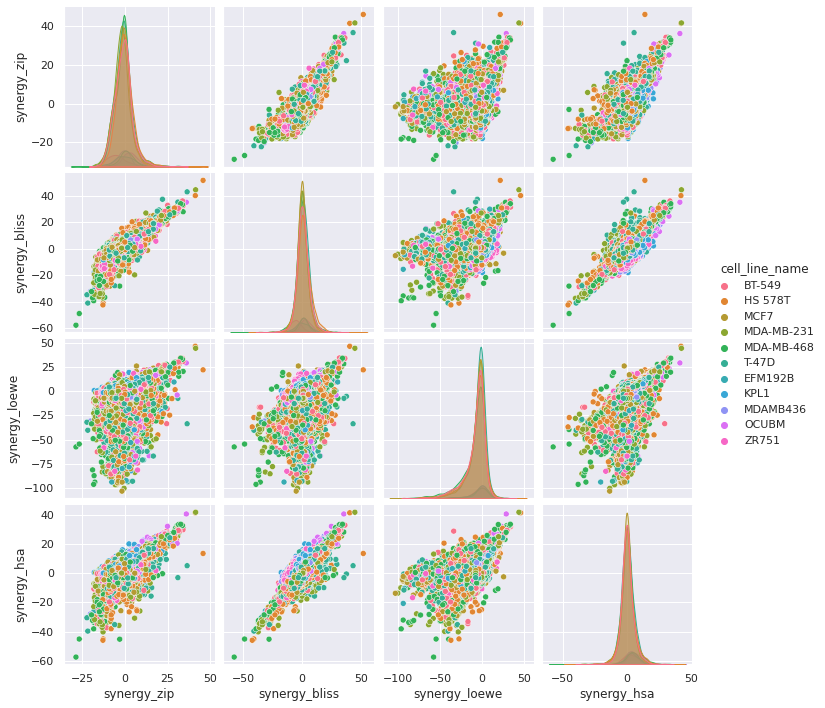

In [45]:
import seaborn as sns
corr_plot = sample_data_03[["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa","cell_line_name"]]
sns.set(font_scale=1)
sns.pairplot(corr_plot, hue="cell_line_name")

#Feature Preparation

##Drug structure


In [ ]:
drug_smiles = {}
for i in all_sample:
  try:
    print(i)
    res = pcp.get_compounds(i, 'name')
    SM = res[0].canonical_smiles   
    drug_smiles[i] = SM
  except Exception:
    pass

In [ ]:
drug_smiles

In [ ]:
tmp_list = []
feat_mat = {}

curated_df = pd.DataFrame(drug_smiles.items(), columns=['Name', 'smiles'])

for i in range(curated_df.shape[0]):

  """
  create normalize adjacency matrix
  """

  mol = Chem.MolFromSmiles(curated_df.iloc[i,1])
  A = Chem.GetAdjacencyMatrix(mol).tolist()
  I = np.eye(A.__len__())

  A_hat = np.array(A + I)

  D_hat = np.array(np.sum(A_hat,axis=0))
  D_hat = np.matrix(np.diag(D_hat))
  D_hat_inv = np.sqrt(D_hat**-1)

  """
  create feaature matrix
  #https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html
  """

  f1 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetIsAromatic() for j in range(mol.GetNumAtoms())]]).T
  f2 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetDegree() for j in range(mol.GetNumAtoms())]]).T
  f3 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetImplicitValence() for j in range(mol.GetNumAtoms())]]).T
  f4 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetMass() for j in range(mol.GetNumAtoms())]]).T
  f5 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetNumImplicitHs() for j in range(mol.GetNumAtoms())]]).T

  X = np.array(pd.concat([f1,f2,f3,f4,f5],axis=1)).astype(int)

  """
  multiplication A_hat*X
  """

  tmp_res = D_hat_inv * A_hat * D_hat_inv * X

  """
  Padding matrix
  """

  tmp_list.append(tmp_res)

  if i == (curated_df.shape[0]-1):
      max_atom_number = max([tmp_list[i].__len__() for i in range(curated_df.shape[0])])
      tmp_pad = pad_sequences(tmp_list, padding='post',maxlen=max_atom_number)
      
      for j in range(curated_df.shape[0]):
        feat_mat[curated_df.iloc[j,0]] = tmp_pad[j]

##Target protein

In [ ]:
target_protein = {}
for i in all_sample:
  try:
    print(i)
    c = pcp.get_compounds(i, 'name')
    pubmed_query_length = str(c[0].cid).__len__()
    add_length = 8 - int(pubmed_query_length)
    stitch_cid = "CIDs"+ '0'*int(add_length) + str(c[0].cid)
    target_prot = np.array(pd.read_csv("http://stitch.embl.de/api/tsv/interactors?identifier="+stitch_cid+"&species=9606",sep="\t").iloc[1:,:])
    if len(target_prot) == 0:
      pass
    elif len(target_prot) > 0:
      target_protein[i] = target_prot
  except Exception:
    pass

###Target protein enrichment

In [345]:
test = [list(target_protein.values())[i].tolist() for i in range(len(target_protein))]
test_01 = sum(sum(test, []),[])
final = [s.replace('9606.',"") for s in test_01]
len(final)

945

In [ ]:
string_ids = stringdb.get_string_ids(final)
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)
enrichment_df

In [ ]:
PI3K_gene = enrichment_df[enrichment_df.category == "KEGG"]
PI3K_gene_plt = PI3K_gene.iloc[:50,:]
PI3K_gene_plt['-log(pvalue)'] =  -np.log(PI3K_gene_plt['p_value'])

<Figure size 720x1440 with 0 Axes>

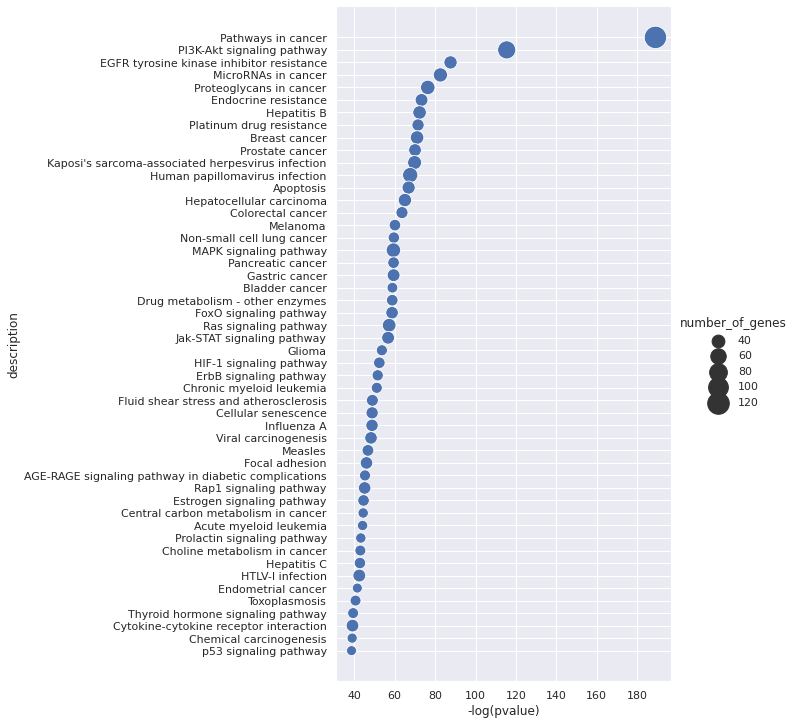

In [343]:
plt.figure(figsize=(10,20))

sns.relplot(x="-log(pvalue)", y="description", size="number_of_genes",
            sizes=(100, 500), palette="muted",
            height=10, data=PI3K_gene_plt)

In [ ]:
PI3K_gene_list = PI3K_gene.iloc[1,5].split(",")
PI3K_gene_list_02 = ["9606."+i for i in PI3K_gene_list]
PI3K_gene_list_02

In [174]:
tmp_dict = {}

for i in range(len(target_protein)):
  query_list = set(sum(list(target_protein.values())[i].tolist(),[]))
  ref_list = set(PI3K_gene_list_02)
  res_list = list(query_list & ref_list)
  tmp_dict[list(target_protein.keys())[i]] = res_list


In [175]:
res_tmp = pd.DataFrame(tmp_dict.items())
res_tmp.columns = ['a', 'b']
res_tmp

,a,b
0,5-FLUORO-2'-DEOXYURIDINE,[]
1,5-FU,"[9606.ENSP00000269305, 9606.ENSP00000276927, 9..."
2,ABIRATERONE,[]
3,ABT-888,"[9606.ENSP00000418960, 9606.ENSP00000275493]"
4,ACTINOMYCIN D,[]
...,...,...
103,VINCRISTINE SULFATE,[9606.ENSP00000269305]
104,VINORELBINE,"[9606.ENSP00000269571, 9606.ENSP00000275493]"
105,VISMODEGIB,[]
106,ZOLEDRONIC ACID,"[9606.ENSP00000270202, 9606.ENSP00000361125, 9..."


In [344]:
res_tmp_filter = res_tmp.loc[res_tmp.b.str.len()>0]
res_tmp_filter

,a,b
1,5-FU,"[9606.ENSP00000269305, 9606.ENSP00000276927, 9..."
3,ABT-888,"[9606.ENSP00000418960, 9606.ENSP00000275493]"
6,AMIFOSTINE,"[9606.ENSP00000269305, 9606.ENSP00000384273, 9..."
8,ANASTROZOLE,[9606.ENSP00000269571]
10,ANTIBIOTIC AY 22989,"[9606.ENSP00000307272, 9606.ENSP00000270202, 9..."
...,...,...
101,VINBLASTINE,[9606.ENSP00000356694]
103,VINCRISTINE SULFATE,[9606.ENSP00000269305]
104,VINORELBINE,"[9606.ENSP00000269571, 9606.ENSP00000275493]"
106,ZOLEDRONIC ACID,"[9606.ENSP00000270202, 9606.ENSP00000361125, 9..."


In [ ]:
gene_count = []
for i in range(res_tmp_filter.shape[0]):
  gene_count.append(res_tmp_filter.iloc[i,1].__len__())

res_tmp_filter["CNT"] = gene_count
res_tmp_filter


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


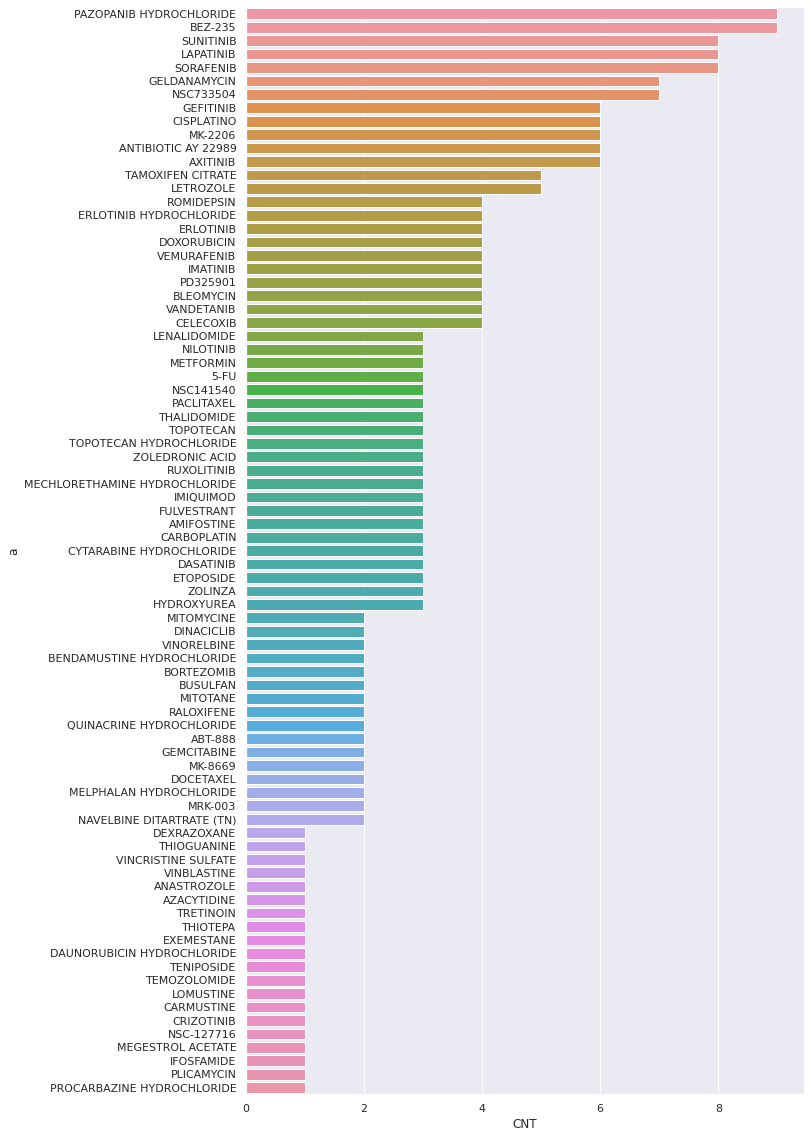

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,20))
x = res_tmp_filter.iloc[:,0]
y = res_tmp_filter.iloc[:,2]
sns.barplot(y,x,
            order=res_tmp_filter.sort_values('CNT',ascending = False).a)
plt.show()

##Boolean

In [ ]:
# Some code to return a Pandas dataframe, given tabular text
def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)
! pip install Bio
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import pandas as pd
import io


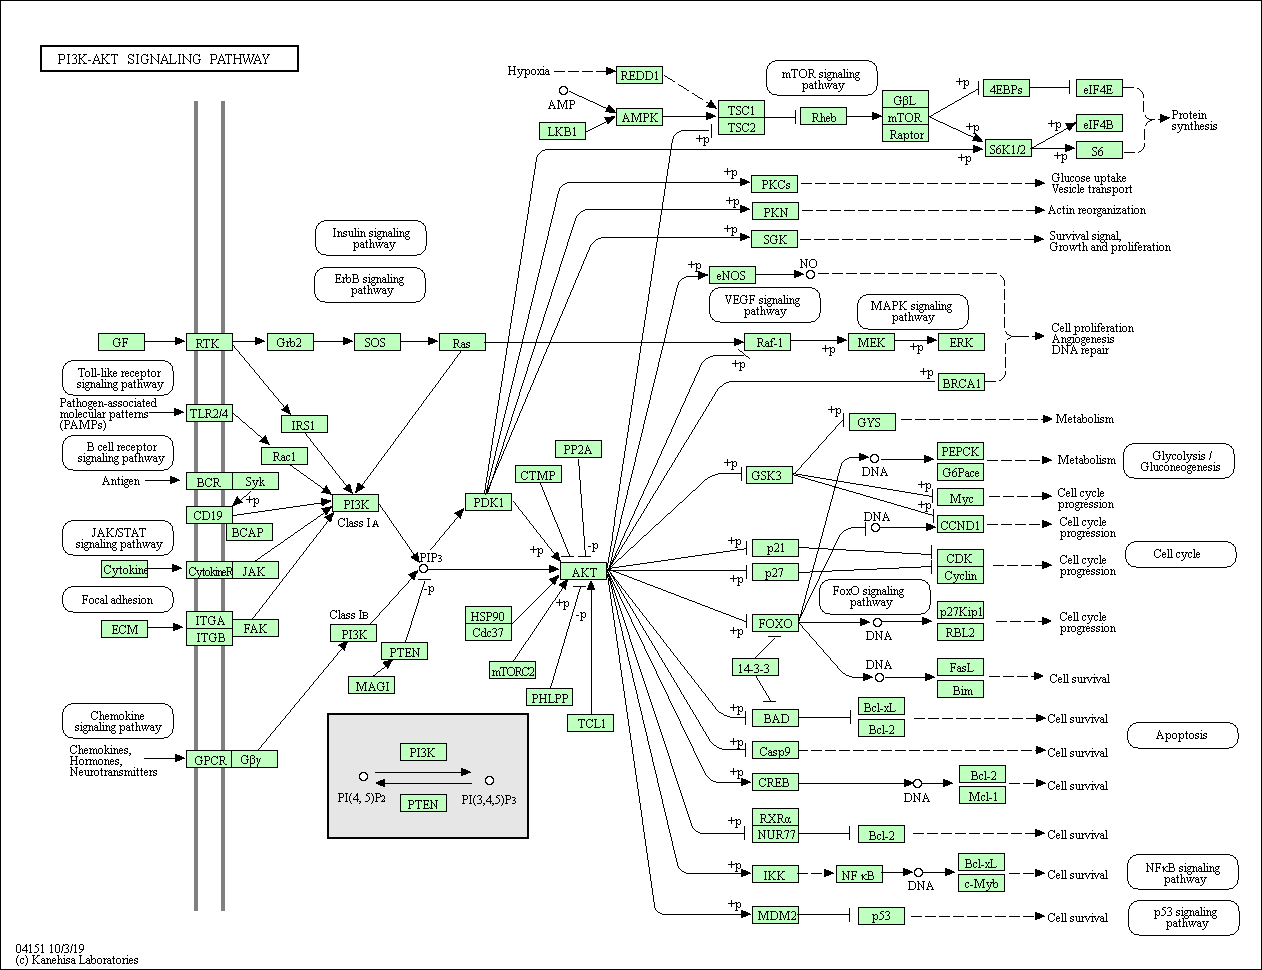

In [116]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
s = REST.kegg_get("hsa04151","image").read()
Image(s)

In [ ]:
s = REST.kegg_get("hsa04151","kgml").read()
print(s)

In [ ]:
#! pip install stringdb
#import stringdb
hsa_KEGG = str(REST.kegg_link("hsa", "hsa04151").read()).replace("path:hsa04151\t","").split("\n")
string_ids_boolean = stringdb.get_string_ids(hsa_KEGG)
string_ids_boolean_dict =  pd.Series(string_ids_boolean.preferredName.values,index=string_ids_boolean.queryItem).to_dict()
string_ids_boolean_dict

In [ ]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
import random
s = REST.kegg_get("hsa04151","kgml").read()
s = keymap_replace(str(s), string_ids_boolean_dict)
tmp_list = [str(read(s).relations[i]) for i in range(read(s).relations.__len__())]
tmp_list

In [308]:
dict_kegg_tmp = []

for i in range(read(s).relations.__len__()):
  try:
    node_1 = tmp_list[i].split("\n")[3]
    node_1_type = tmp_list[i].split("\n")[4]
    node_2 = tmp_list[i].split("\n")[11]
    node_2_type = tmp_list[i].split("\n")[12]
    relations = tmp_list[i].split("\n")[18]
    tmp_res_02 = [node_2,"=",node_1,"[","Relation:",relations,"and type:" ,node_1_type,"&",node_2_type,"]"] 
    res_bool = " ".join(tmp_res_02).replace("Names:","").replace("Type:","")
    open("Boolean_final.txt","a").write(res_bool + "\n")
  except Exception:
    pass

In [ ]:
f = open("Boolean_final.txt", "r")
f.readlines()

##Cell line

Useful resource: https://depmap.org/portal/download/

In [ ]:
cell_line = pd.read_csv("https://github.com/kittisaktaoma/colab_practice/raw/master/data/Mutation_profile.csv.gz")
cell_line.iloc[:,0].unique()

In [ ]:
df_model = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/data/sample.txt",sep="\t").iloc[:,9]
df_model_list = list(df_model.unique())
df_model_list

In [ ]:
new_name_01 = [i.replace("-","") for i in df_model_list]
new_name_final = [i.replace(" ","") for i in new_name_01]
new_name_final

In [293]:
cell_line_final = cell_line[cell_line["cell_line_display_name"].isin(new_name_final)]
cell_line_final

,cell_line_display_name,lineage_4,VPS13D,AADACL4,IFNLR1,MACO1,ZSCAN20,POU3F1,MAST2,GBP4,VAV3,NBPF20,FLG2,RHBG,FCRL5,SPTA1,CFAP126,DUSP12,QSOX1,EPRS1,RGS7,ZBTB18,PCBD1,ECD,ZNF503,PDZD7,SORCS1,GFRA1,CPXM2,TCERG1L,MUC5B,BRSK2,SYT8,OSBPL5,MMP26,BBOX1,METTL15,KBTBD4,OR4C3,OR4C12,...,CASP6,CD14,H2AC15,SMAP1,LHFPL3,TRMT12,DEPP1,TMEM116,EMP3,HOPX,EFNA4,TACR2,ENO4,FOXN4,PSMC6,PCTP,TST,KLF15,CEP19,KLF3,PPP1R18,PSORS1C1,AFG1L,SEC61G,DOK2,ACER2,TNFSF8,MED8,IFI27L2,GFPT1,KLHL41,KRTAP25-1,USP46,CRHBP,AGPAT1,MAN1A1,PURB,CTAGE6,OR1L3,S100G
7,KPL1,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,MCF7,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,T47D,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,ZR751,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,BT549,Basal B,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,HS578T,Basal B,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,MDAMB231,Basal B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
38,MDAMB436,Basal B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55,MDAMB468,Basal A,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64,OCUBM,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



# Data Preparation

In [ ]:
df_sample = sample_data_03[["drug_row","drug_col","cell_line_name","synergy_loewe"]]
df_sample


## Filter cell line

In [ ]:
df_sample["cell_line_name"].replace({"T-47D": "T47D", 
                                    "MDA-MB-468": "MDAMB468",
                                    "MDA-MB-231": "MDAMB231",
                                    "BT-549": "BT549",
                                    "HS 578T": "HS578T"}, inplace=True)
filter_list = cell_line_final.iloc[:,0].unique()
cell_line_filter_df = df_sample[df_sample["cell_line_name"].isin(filter_list)]
cell_line_filter_df

## Filter drug

In [ ]:
#list of remaining drug in cell line
cell_line_drug_row_remaining = np.unique(cell_line_filter_df.iloc[:,0].unique())
cell_line_drug_col_remaining = np.unique(cell_line_filter_df.iloc[:,1].unique())
cell_line_drug_remaining = set(list(np.unique(np.concatenate((cell_line_drug_col_remaining,cell_line_drug_col_remaining)))))

#list of remaining drug in target protein
remaingin_drug_target_protein = set(list(target_protein.keys()))

#list of remaining drug in drug structure
remaingin_drug_structure = set(list(feat_mat.keys()))

available_drug = list(remaingin_drug_target_protein & cell_line_drug_remaining & remaingin_drug_structure)


##FInal Datset (Index Data)

In [ ]:
cell_line_filter_df_02 = cell_line_filter_df[cell_line_filter_df["drug_row"].isin(available_drug)]
cell_line_filter_df_03 = cell_line_filter_df_02[cell_line_filter_df_02["drug_col"].isin(available_drug)]
cell_line_filter_df_03

,drug_row,drug_col,cell_line_name,synergy_loewe
618,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,BT549,0.23
619,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,HS578T,-11.50
620,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MCF7,-49.33
621,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB231,-4.25
622,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB468,-6.41
...,...,...,...,...
34781,ZOLINZA,ZOLEDRONIC ACID,HS578T,-3.55
34782,ZOLINZA,ZOLEDRONIC ACID,MCF7,-7.20
34783,ZOLINZA,ZOLEDRONIC ACID,MDAMB231,-7.43
34784,ZOLINZA,ZOLEDRONIC ACID,MDAMB468,-7.69


## Get feature of remaining drug & cell line

### Target Protein

In [ ]:
newDF = pd.DataFrame() 

target_protein_filter = {k: target_protein[k] for k in available_drug}

for i in range(target_protein_filter.__len__()):
  df_annotated = pd.DataFrame(pd.DataFrame(list(target_protein_filter.values())[i].tolist()))
  df_annotated["drug"] = list(target_protein_filter.keys())[i]
  newDF = df_annotated.append(newDF)
newDF.columns = ['protein','drug']
newDF

In [ ]:
crosstab_df_target_protein = pd.crosstab(newDF["drug"],newDF['protein']).stack().reset_index(name='Freq')
crosstab_df_target_protein_02 = pd.pivot_table(crosstab_df_target_protein,index='drug', columns='protein',values='Freq').reset_index()
crosstab_df_target_protein_03 = crosstab_df_target_protein_02.iloc[:,0:]
crosstab_df_target_protein_03

In [ ]:
def process(i):
  print(i)
  index_drug = cell_line_filter_df_03.iloc[i,:2].tolist()
  drug_row = crosstab_df_target_protein_03[crosstab_df_target_protein_03.drug == index_drug[0]]
  drug_row_02 = drug_row.rename(columns={'drug': 'drug_row'})
  
  drug_col = crosstab_df_target_protein_03[crosstab_df_target_protein_03["drug"] == index_drug[1]]
  drug_col_02 = drug_col.rename(columns={'drug': 'drug_col'})
  res_app = pd.concat([drug_row_02.reset_index(drop=True),drug_col_02.reset_index(drop=True)],axis=1)

  res_app_2 = res_app.sort_index(axis=1).iloc[:,:988]
  res_app_tmp = res_app.sort_index(axis=1).iloc[:,988:]
  
  final_df = pd.concat([res_app_tmp,res_app_2],axis=1)
  return(final_df)
 

In [ ]:
target_protein_df = pd.concat([process(i) for i in range(cell_line_filter_df_03.shape[0])])
#target_protein_df.to_csv('target_protein_df.csv.gz', compression='gzip')

In [ ]:
target_protein_df

protein,drug_col,drug_row,9606.ENSP00000001008,9606.ENSP00000001008,9606.ENSP00000001146,9606.ENSP00000001146,9606.ENSP00000013807,9606.ENSP00000013807,9606.ENSP00000037502,9606.ENSP00000037502,9606.ENSP00000080059,9606.ENSP00000080059,9606.ENSP00000206249,9606.ENSP00000206249,9606.ENSP00000211122,9606.ENSP00000211122,9606.ENSP00000215832,9606.ENSP00000215832,9606.ENSP00000216117,9606.ENSP00000216117,9606.ENSP00000216330,9606.ENSP00000216330,9606.ENSP00000216714,9606.ENSP00000216714,9606.ENSP00000216911,9606.ENSP00000216911,9606.ENSP00000217133,9606.ENSP00000217133,9606.ENSP00000217185,9606.ENSP00000217185,9606.ENSP00000217426,9606.ENSP00000217426,9606.ENSP00000218032,9606.ENSP00000218032,9606.ENSP00000219431,9606.ENSP00000219431,9606.ENSP00000219700,9606.ENSP00000219700,9606.ENSP00000220764,9606.ENSP00000220764,...,9606.ENSP00000413074,9606.ENSP00000413074,9606.ENSP00000414334,9606.ENSP00000414334,9606.ENSP00000417281,9606.ENSP00000417281,9606.ENSP00000417517,9606.ENSP00000417517,9606.ENSP00000418532,9606.ENSP00000418532,9606.ENSP00000418960,9606.ENSP00000418960,9606.ENSP00000419692,9606.ENSP00000419692,9606.ENSP00000419782,9606.ENSP00000419782,9606.ENSP00000420168,9606.ENSP00000420168,9606.ENSP00000425561,9606.ENSP00000425561,9606.ENSP00000427562,9606.ENSP00000427562,9606.ENSP00000430075,9606.ENSP00000430075,9606.ENSP00000430432,9606.ENSP00000430432,9606.ENSP00000434516,9606.ENSP00000434516,9606.ENSP00000441927,9606.ENSP00000441927,9606.ENSP00000457706,9606.ENSP00000457706,9606.ENSP00000459962,9606.ENSP00000459962,9606.ENSP00000462196,9606.ENSP00000462196,9606.ENSP00000463999,9606.ENSP00000463999,9606.ENSP00000464149,9606.ENSP00000464149
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
newDF_prot_02 = pd.DataFrame() 
i = list(target_protein_df.iloc[:,2:].columns.unique())
for k in i:
  print(k)
  x = pd.DataFrame(target_protein_df.loc[:,k].sum(axis=1))
  x.columns = [k]
  newDF_prot_02 = pd.concat([x,newDF_prot_02],axis=1)
final_df_ordinal = pd.concat([target_protein_df.iloc[:,:2], newDF_prot_02],axis=1)

In [ ]:
final_df_ordinal

,drug_col,drug_row,9606.ENSP00000464149,9606.ENSP00000463999,9606.ENSP00000462196,9606.ENSP00000459962,9606.ENSP00000457706,9606.ENSP00000441927,9606.ENSP00000434516,9606.ENSP00000430432,9606.ENSP00000430075,9606.ENSP00000427562,9606.ENSP00000425561,9606.ENSP00000420168,9606.ENSP00000419782,9606.ENSP00000419692,9606.ENSP00000418960,9606.ENSP00000418532,9606.ENSP00000417517,9606.ENSP00000417281,9606.ENSP00000414334,9606.ENSP00000413074,9606.ENSP00000412237,9606.ENSP00000411532,9606.ENSP00000410076,9606.ENSP00000408860,9606.ENSP00000408695,9606.ENSP00000408632,9606.ENSP00000402861,9606.ENSP00000402084,9606.ENSP00000400175,9606.ENSP00000399985,9606.ENSP00000398698,9606.ENSP00000398495,9606.ENSP00000396704,9606.ENSP00000396308,9606.ENSP00000394932,9606.ENSP00000393583,9606.ENSP00000391676,9606.ENSP00000388902,...,9606.ENSP00000237612,9606.ENSP00000233146,9606.ENSP00000231948,9606.ENSP00000231790,9606.ENSP00000231509,9606.ENSP00000231449,9606.ENSP00000229239,9606.ENSP00000229135,9606.ENSP00000228682,9606.ENSP00000227758,9606.ENSP00000227507,9606.ENSP00000226730,9606.ENSP00000226413,9606.ENSP00000225577,9606.ENSP00000225474,9606.ENSP00000223095,9606.ENSP00000222982,9606.ENSP00000222390,9606.ENSP00000221930,9606.ENSP00000221130,9606.ENSP00000220809,9606.ENSP00000220764,9606.ENSP00000219700,9606.ENSP00000219431,9606.ENSP00000218032,9606.ENSP00000217426,9606.ENSP00000217185,9606.ENSP00000217133,9606.ENSP00000216911,9606.ENSP00000216714,9606.ENSP00000216330,9606.ENSP00000216117,9606.ENSP00000215832,9606.ENSP00000211122,9606.ENSP00000206249,9606.ENSP00000080059,9606.ENSP00000037502,9606.ENSP00000013807,9606.ENSP00000001146,9606.ENSP00000001008
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,ZOLEDRONIC ACID,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
cell_line_filter_df_03.head()

,drug_row,drug_col,cell_line_name,synergy_loewe
618,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,BT549,0.23
619,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,HS578T,-11.50
620,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MCF7,-49.33
621,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB231,-4.25
622,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB468,-6.41


In [ ]:
score = pd.DataFrame(cell_line_filter_df_03.iloc[:,3]).reset_index(drop=True)
f1 = final_df_ordinal.reset_index(drop=True)
target_protein_df = pd.concat([f1,score],axis=1)
target_protein_df
target_protein_df.to_csv('target_ordinal_df.csv.gz', compression='gzip')

###Drug structure

In [ ]:
drug_1_index = list(cell_line_filter_df_03.iloc[:,0])
drug_2_index = list(cell_line_filter_df_03.iloc[:,1])

#### Drug row

In [ ]:
drug_structure_1_list = []
drug_1_index = cell_line_filter_df_03.iloc[:,0]
drug_structure_01 = {k: feat_mat[k] for k in available_drug}
for i in drug_1_index:
  selected_drug = drug_structure_01[i].tolist()
  drug_structure_1_list.append(selected_drug)
drug_structure_1_list

#### Drug column

In [ ]:
drug_structure_2_list = []
drug_2_index = cell_line_filter_df_03.iloc[:,1]
drug_structure_02 = {k: feat_mat[k] for k in available_drug}
for i in drug_2_index:
  selected_drug = drug_structure_02[i].tolist()
  drug_structure_2_list.append(selected_drug)

In [ ]:
drug_structure_1_array = np.array(drug_structure_1_list).astype('float32')
drug_structure_2_array = np.array(drug_structure_2_list).astype('float32')

In [ ]:
import pickle
pickle_out = open("drug_structure_2.pickle","wb")
pickle.dump(drug_structure_2_array, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("drug_structure_1.pickle","rb")
example_dict = pickle.load(pickle_in)
example_dict

In [ ]:
len(example_dict)

24566

### Cell line

In [ ]:
cell_line_final

In [ ]:
dict_cell_line = {}

for i in range(len(cell_line_name)):
  cell_line_name = cell_line_final.iloc[i,0]
  geno_profile = list(cell_line_final.iloc[i,2:])
  dict_cell_line[cell_line_name] = geno_profile

dict_cell_line
  

In [ ]:
cell_line_list = []
cell_line_index = cell_line_filter_df_03.iloc[:,2]
cnt = 0
for i in cell_line_index:
  print(cnt)
  selected_cell_line = dict_cell_line[i]
  cell_line_list.append(selected_cell_line)
  cnt=cnt+1


In [ ]:
cell_line_feature = np.array(cell_line_list)

### Save file

In [ ]:
import pickle
pickle_out = open("drug_structure_1.pickle","wb")
pickle.dump(drug_structure_1_array, pickle_out)
pickle_out.close()

pickle_out = open("drug_structure_2.pickle","wb")
pickle.dump(drug_structure_2_array, pickle_out)
pickle_out.close()

pickle_out = open("target_protein.pickle","wb")
pickle.dump(target_protein_df, pickle_out)
pickle_out.close()

pickle_out = open("cell_line_feature.pickle","wb")
pickle.dump(cell_line_feature, pickle_out)
pickle_out.close()

pickle_out = open("index_dataframe.pickle","wb")
pickle.dump(cell_line_filter_df_03, pickle_out)
pickle_out.close()


pickle_out = open("index_dataframe.pickle","wb")
pickle.dump(cell_line_filter_df_03, pickle_out)
pickle_out.close()

## Get Pickle file

In [ ]:
from io import BytesIO
import pickle
import requests
def get_pickle(feature):
   mLink = "https://github.com/kittisaktaoma/colab_practice/raw/master/feature_object/"+feature+".pickle"
   mfile = BytesIO(requests.get(mLink).content)
   df = pickle.load(mfile)
   return (df) 

In [ ]:
drug_structure_1 = get_pickle("drug_structure_1")
drug_structure_2 = get_pickle("drug_structure_2")
cell_line_feature = get_pickle("cell_line_features")
target_protein_feature = np.array(get_pickle("target_protein").iloc[:,2:496])
index_dataframe_df = get_pickle("index_dataframe")
index_dataframe_df

,drug_row,drug_col,cell_line_name,synergy_loewe
618,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,BT549,0.23
619,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,HS578T,-11.50
620,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MCF7,-49.33
621,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB231,-4.25
622,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB468,-6.41
...,...,...,...,...
34781,ZOLINZA,ZOLEDRONIC ACID,HS578T,-3.55
34782,ZOLINZA,ZOLEDRONIC ACID,MCF7,-7.20
34783,ZOLINZA,ZOLEDRONIC ACID,MDAMB231,-7.43
34784,ZOLINZA,ZOLEDRONIC ACID,MDAMB468,-7.69


#Model

##Graph convolutional layer

In [ ]:
class GraphConv(Layer):
    
    """
    GraphConv require two inputs: padding feature and padding adjacency matrix of each drug

    """
    def __init__(self,output_dim,activation="sigmoid"):
        super().__init__()
        self.units = output_dim
        self.activation_function = activation

    def build(self, input_shape):
        
        """ 
        weight in GCN : 
        row is number of feature
        column is the number of output node

        """
        self.w = self.add_weight(name='w',
            shape=(input_shape[-1], self.units), 
            initializer="random_normal",
            trainable=True)
        
    

    def call(self,inputs):
      """
      Inputs = padding feature matrix 
      A = padding adjacency matrix

      """
      if self.activation_function == 'relu':
        return relu(inputs @ self.w)
      else:
        return sigmoid(inputs @ self.w)

## Model Achitecture

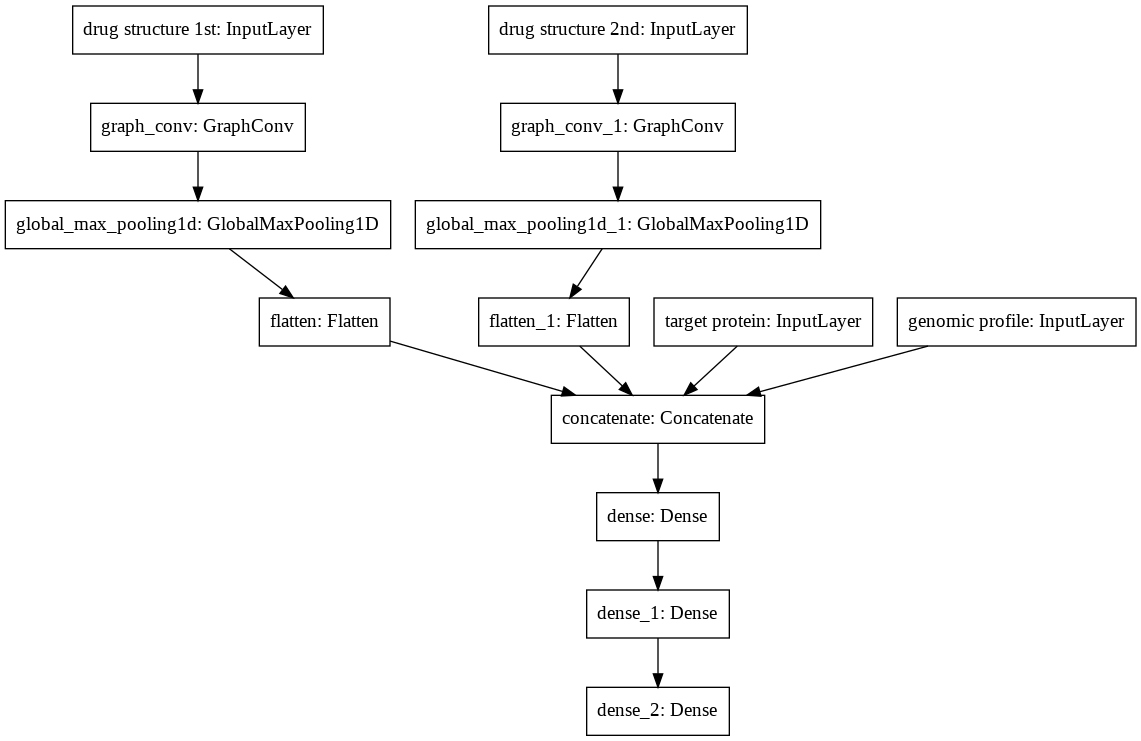

In [ ]:
#drug structure_1
drug_01 = Input(shape=(96,5),name="drug structure 1st")
drug_01_layer1 = GraphConv(2,activation='relu')(drug_01)
drug_01_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_01_layer1)
flat1 = Flatten()(drug_01_pool)

#drug structure_2
drug_02 = Input(shape=(96,5),name="drug structure 2nd")
drug_02_layer1 = GraphConv(2,activation='relu')(drug_02)
drug_02_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_02_layer1)
flat2 = Flatten()(drug_02_pool)
#target protein
flat3 = Input(shape=(494,),name="target protein")

#geno profiel
flat4 = Input(shape=(16380,),name="genomic profile")


#merge input models
merge = concatenate([flat1,flat2,flat3,flat4])

#interpretation model
# interpretation model
hidden1 = Dense(2000, activation='relu')(merge)
hidden2 = Dense(2000, activation='relu')(hidden1)
output = Dense(1)(hidden2)
model = Model(inputs=[flat4,flat3,drug_01,drug_02], outputs=output)
plot_model(model, to_file='multilayer_perceptron_graph.png')

## Customized Evaluation metric

Pearson correlation coefficlent : $r_{xy} = \frac{\sum\left((x-\overline{x})(y-\overline{y})\right)}{\sqrt{\sum(x-\overline{x})^2\sum(y-\overline{y})^2}} $

In [ ]:
def correlation(y_actual, y_predict):    
    y_actual_me = tf.math.reduce_mean(y_actual)
    y_predict_me = tf.math.reduce_mean(y_predict)
    y_actual_diff, y_predict_diff = y_actual-y_actual_me, y_predict-y_predict_me

    num = tf.math.reduce_sum(tf.multiply(y_predict_diff,y_actual_diff))
    deno = tf.math.pow(tf.multiply(tf.math.reduce_sum(tf.math.pow(y_actual_diff,2)),
                              tf.math.reduce_sum(tf.math.pow(y_predict_diff,2))),0.5) 
    res = num/deno
    return res

def correlation_neg(y_actual, y_predict):    
    y_actual_me = tf.math.reduce_mean(y_actual)
    y_predict_me = tf.math.reduce_mean(y_predict)
    y_actual_diff, y_predict_diff = y_actual-y_actual_me, y_predict-y_predict_me

    num = tf.math.reduce_sum(tf.multiply(y_predict_diff,y_actual_diff))
    deno = tf.math.pow(tf.multiply(tf.math.reduce_sum(tf.math.pow(y_actual_diff,2)),
                              tf.math.reduce_sum(tf.math.pow(y_predict_diff,2))),0.5) 
    res = -num/deno
    return res

## Finding optimal hyperparameter

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.model_selection import KFold

In [ ]:
params = {'activation_1': ["relu", "tanh"],
          'activation_2': ["relu", "tanh"],
          'layer_1': np.arange(500, 10000,1).tolist(),
          'layer_2': np.arange(500, 10000,1).tolist(),
          'dropout_1' : np.arange(0, 0.05, 0.001).tolist(),
          'dropout_2' : np.arange(0, 0.05, 0.001).tolist(),
          'batch_size': [128,256,512], 
          'epochs': [30],
          'optimizer_algorithm' : ["1","2"],
          'lr': np.arange(0.000000001, 0.01, 0.00000001).tolist()}

In [ ]:
def my_model(layer_1,dropout_1,activation_1,layer_2,dropout_2,activation_2,optimizer_algorithm,lr):
  
  """
  Define model Architecture
  """

  #drug structure_1
  drug_01 = Input(shape=(96,5))
  drug_01_layer1 = GraphConv(3,activation='relu')(drug_01)
  drug_01_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_01_layer1)
  flat1 = Flatten()(drug_01_pool)
  
  #drug structure_2
  drug_02 = Input(shape=(96,5))
  drug_02_layer1 = GraphConv(3,activation='relu')(drug_02)
  drug_02_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_02_layer1)
  flat2 = Flatten()(drug_02_pool)
  
  #target protein
  flat3 = Input(shape=(494,))
  
  #geno profiel
  flat4 = Input(shape=(98,))
  merge = concatenate([flat1,flat2,flat3,flat4])
  
  #interpretation model
  hidden1 = Dense(layer_1,
                  activation=activation_1)(merge)
  hidden1_D = Dropout(rate=dropout_1)(hidden1)
  hidden2 = Dense(layer_2,
                  activation=activation_2)(hidden1_D)
  hidden2_D = Dropout(rate=dropout_2)(hidden2)
  output = Dense(1)(hidden2_D)
  
   #optimizer
  if optimizer_algorithm == "1": 
    opt = Adam(learning_rate=lr)
  elif optimizer_algorithm == "2":
    opt = RMSprop(learning_rate=lr)


  model = Model(inputs=[drug_01,drug_02,flat3,flat4], outputs=output)
  model.compile(optimizer=opt,
              loss=correlation_neg,
              metrics=correlation)
  return model

In [ ]:
def my_model_cross_validation (hyperparameter_set,n_fold):
  """
  Assign the hyperparameter value
  """
  hyper_set = {}
  hyper_set["hyperparameter_set"] = hyperparameter_set
  hyper_set["activation_1"] = random.choice(params['activation_1'])
  hyper_set["activation_2"] = random.choice(params['activation_2'])
  hyper_set["layer_1"] = random.choice(params['layer_1'])
  hyper_set["layer_2"] = random.choice(params['layer_2'])
  hyper_set["dropout_1"] = random.choice(params['dropout_1'])
  hyper_set["dropout_2"] = random.choice(params['dropout_2'])
  hyper_set['batch_size'] = random.choice(params['batch_size'])
  hyper_set['epochs'] = random.choice(params['epochs'])
  hyper_set['optimizer_algorithm'] = random.choice(params['optimizer_algorithm'])
  hyper_set['lr'] = random.choice(params['lr'])
  
  my_model_fig = my_model(hyper_set.get("layer_1"),hyper_set.get("dropout_1"),hyper_set.get("activation_1"),
               hyper_set.get("layer_2"),hyper_set.get("dropout_2"),hyper_set.get("activation_2"),
               hyper_set.get("optimizer_algorithm"),hyper_set.get("lr"))

  """
  SPLIT DATA 80:20
  """

  index_dataframe_df.reset_index(drop=True, inplace=True)
  train_tmp_index = index_dataframe_df.sample(frac=0.80,random_state=123)
  index_all = list(index_dataframe_df.index)
  train_index = list(train_tmp_index.index)
  test_index = list(set(index_all) - set(train_index))

  X_train_drug_structure_1, X_test_drug_structure_1 = drug_structure_1[train_index],drug_structure_1[test_index]
  X_train_drug_structure_2, X_test_drug_structure_2 = drug_structure_2[train_index],drug_structure_2[test_index]
  X_train_target_protein, X_test_target_protein = target_protein_feature[train_index],target_protein_feature[test_index]
  X_train_cell_line_feature, X_test_cell_line_feature = cell_line_feature[train_index],cell_line_feature[test_index]
  X_train_synergy_score, X_test_synergy_score =  np.array(index_dataframe_df.iloc[:,3])[train_index],np.array(index_dataframe_df.iloc[:,3])[test_index]
  
  """
  Tuning hyperparemeter
  """

  hist_train = []
  hist_validation = []

  kf = KFold(n_splits=n_fold,random_state=123,shuffle=True)
  for train_in, test_in in kf.split(train_tmp_index):
    print("TRAIN:", train_in, "TEST:", test_in)
    X_TRAIN_D1_ST, X_TEST_D1_ST = X_train_drug_structure_1[train_in],  X_train_drug_structure_1[test_in]
    X_TRAIN_D2_ST, X_TEST_D2_ST = X_train_drug_structure_2[train_in], X_train_drug_structure_2[test_in] 
    X_TRAIN_TARGET, X_TEST_TARGET = X_train_target_protein[train_in], X_train_target_protein[test_in] 
    X_TRAIN_GENO, X_TEST_GENO = X_train_cell_line_feature[train_in], X_train_cell_line_feature[test_in] 
    X_TRAIN_SCORE, X_TEST_SCORE = X_train_synergy_score[train_in], X_train_synergy_score[test_in] 
    
    model = my_model_fig
    #train
    """
    80 % of data is used in tuning hyperparemeter
    """

    hist = model.fit([X_TRAIN_D1_ST,X_TRAIN_D2_ST,X_TRAIN_TARGET,X_TRAIN_GENO],X_TRAIN_SCORE,
                    validation_data=([X_TEST_D1_ST,X_TEST_D2_ST,X_TEST_TARGET,X_TEST_GENO],X_TEST_SCORE),
                    epochs=hyper_set.get("epochs"),batch_size=hyper_set.get("batch_size"))
    
    """
    20 % of data is used in test the tune hyperparameter
    """    
    #test
    res_predict = hist.model.evaluate([X_test_drug_structure_1,X_test_drug_structure_2,
                                 X_test_target_protein,X_test_cell_line_feature],X_test_synergy_score)
  
    hist_train.append(hist.history["correlation"])
    hist_validation.append(hist.history["val_correlation"]) 


  """
  collect the result for each hyperparameter
  """
  hyper_set["train_correlation"] = [hist_train[i][0] for i in range(n_fold)]
  hyper_set["val_correlation"] = [hist_validation[i][0] for i in range(n_fold)]
  hyper_set["Mean_train_correlation"] = np.mean(hyper_set.get('train_correlation'))
  hyper_set["Mean_val_correlation"] = np.mean(hyper_set.get('val_correlation'))
  hyper_set["test_correlation"] = res_predict[1]
  hyper_set["n_fold"] = n_fold

  return hyper_set

In [ ]:
import random
res_model = []
for i in range(10):
  print(i)
  res =  my_model_cross_validation(hyperparameter_set="Set"+str(i),n_fold=3)
  res_model.append(res)

0
TRAIN: [    0     1     3 ... 19650 19651 19652] TEST: [    2     8     9 ... 19640 19642 19644]
Epoch 1/30
26/26 [==============================] - 2s 55ms/step - loss: -0.2550 - correlation: 0.2551 - val_loss: -0.4028 - val_correlation: 0.4026
Epoch 2/30
26/26 [==============================] - 1s 47ms/step - loss: -0.3972 - correlation: 0.3972 - val_loss: -0.4274 - val_correlation: 0.4275
Epoch 3/30
26/26 [==============================] - 1s 47ms/step - loss: -0.4338 - correlation: 0.4338 - val_loss: -0.4629 - val_correlation: 0.4632
Epoch 4/30
26/26 [==============================] - 1s 47ms/step - loss: -0.4927 - correlation: 0.4928 - val_loss: -0.5205 - val_correlation: 0.5205
Epoch 5/30
26/26 [==============================] - 1s 48ms/step - loss: -0.5368 - correlation: 0.5369 - val_loss: -0.5426 - val_correlation: 0.5425
Epoch 6/30
26/26 [==============================] - 1s 48ms/step - loss: -0.5602 - correlation: 0.5601 - val_loss: -0.5755 - val_correlation: 0.5755
Epoch 7

In [ ]:
res_metric = []
for i in range(10):
  metric_ = [res_model[i].get("Mean_train_correlation"),
             res_model[i].get("Mean_val_correlation"),
             res_model[i].get("test_correlation")]
  res_metric.append(metric_)  

In [ ]:
res_metric

[[0.6849348942438761, 0.7531202137470245, 0.7381267547607422],
 [0.7007171909014384, 0.7836348017056783, 0.7473207712173462],
 [0.7053010861078898, 0.7493664423624674, 0.7469838857650757],
 [0.7032027939955393, 0.7591814597447714, 0.7540690898895264],
 [0.6587284108002981, 0.721853772799174, 0.6994878053665161],
 [0.6517330706119537, 0.6879836122194926, 0.6895944476127625],
 [0.66407909989357, 0.7557060321172079, 0.7125269770622253],
 [0.6401560604572296, 0.6909554302692413, 0.6872953772544861],
 [0.6504105925559998, 0.7240430215994517, 0.7076599597930908],
 [0.5935071905454, 0.6265928745269775, 0.6840773820877075]]

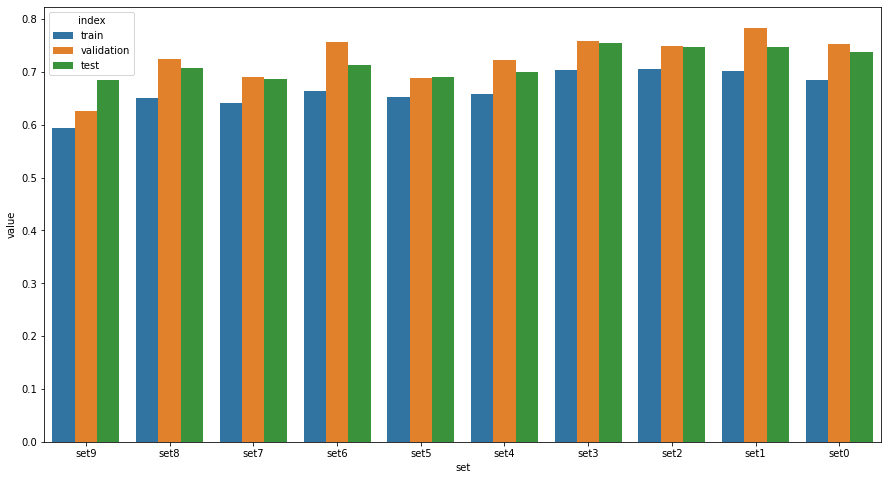

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

newDF = pd.DataFrame() 
 
for i in range(res_metric.__len__()):
  df_01 = pd.DataFrame(res_metric[i], columns=['value'])
  df_index = pd.DataFrame(['train','validation','test'], columns=['index'])
  df_final = pd.concat([df_01,df_index],axis=1)
  df_final["set"] = "set"+str(i)
  newDF = df_final.append(newDF)

plt.figure(figsize=(15,8))
sns.barplot(x="set", y="value",
            hue="index",
            data=newDF)

##Save result as PICKLE

In [ ]:
import pickle
pickle_out = open("result_modelling.pickle","wb")
pickle.dump(res_model, pickle_out)
pickle_out.close()

In [ ]:
from io import BytesIO
import pickle
import requests
mLink = "https://github.com/kittisaktaoma/colab_practice/raw/master/result_modelling.pickle"
mfile = BytesIO(requests.get(mLink).content)
res_mol_pickle = pickle.load(mfile)
res_mol_pickle

##Create Leave-drug-combination and cell-line out index

In [ ]:
index_LDO = index_dataframe_df.iloc[:,:2].groupby(["drug_row","drug_col"]).count().reset_index()
index_LDO["drug_comb_index"] = range(index_LDO.shape[0])
index_df_cv = pd.merge(index_dataframe_df,index_LDO)
index_df_cv

,drug_row,drug_col,cell_line_name,synergy_loewe,drug_comb_index
0,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,BT549,0.23,0
1,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,HS578T,-11.50,0
2,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MCF7,-49.33,0
3,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB231,-4.25,0
4,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB468,-6.41,0
...,...,...,...,...,...
24561,ZOLINZA,ZOLEDRONIC ACID,HS578T,-3.55,4210
24562,ZOLINZA,ZOLEDRONIC ACID,MCF7,-7.20,4210
24563,ZOLINZA,ZOLEDRONIC ACID,MDAMB231,-7.43,4210
24564,ZOLINZA,ZOLEDRONIC ACID,MDAMB468,-7.69,4210


In [ ]:
index_cell_line_out = pd.DataFrame(index_dataframe_df.iloc[:,2]).groupby(["cell_line_name"]).count().reset_index()
index_cell_line_out["cell_line_index"] = range(index_cell_line_out.shape[0])
index_df_cv_final = pd.merge(index_df_cv,index_cell_line_out)

In [ ]:
index_df_cv_final_sorted = index_df_cv_final.sort_values(['drug_comb_index','cell_line_name'])
index_df_cv_final_sorted

,drug_row,drug_col,cell_line_name,synergy_loewe,drug_comb_index,cell_line_index
0,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,BT549,0.23,0,0
3673,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,HS578T,-11.50,0,1
7319,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MCF7,-49.33,0,3
11031,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB231,-4.25,0,4
14740,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB468,-6.41,0,6
...,...,...,...,...,...,...
7318,ZOLINZA,ZOLEDRONIC ACID,HS578T,-3.55,4210,1
11030,ZOLINZA,ZOLEDRONIC ACID,MCF7,-7.20,4210,3
14739,ZOLINZA,ZOLEDRONIC ACID,MDAMB231,-7.43,4210,4
18397,ZOLINZA,ZOLEDRONIC ACID,MDAMB468,-7.69,4210,6


##Re-Evaluate optimized model 

###leave-cell-line-out CV

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
hist_LCO_train = []
hist_LCO_validation = []
optimal_hyperparameter = res_mol_pickle[1]



index_leave_drug_out = drug_structure_1
syn_score = np.array(index_dataframe_df.iloc[:,3])
groups = index_df_cv_final_sorted.iloc[:,5]
logo = LeaveOneGroupOut()

for train_index, test_index in logo.split(drug_structure_1, syn_score, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    Drug_1_train, Drug_1_test = drug_structure_1[train_index], drug_structure_1[test_index]
    Drug_2_train, Drug_2_test = drug_structure_2[train_index], drug_structure_2[test_index]
    Target_protein_train,Target_protein_test = target_protein_feature[train_index],target_protein_feature[test_index]
    Cell_line_feature_train, Cell_line_feature_test = cell_line_feature[train_index],cell_line_feature[test_index]
    Synergy_score_train, Synergy_score_test =  syn_score[train_index],syn_score[test_index]

    my_model_fig = my_model(optimal_hyperparameter.get("layer_1"),optimal_hyperparameter.get("dropout_1"),optimal_hyperparameter.get("activation_1"),
               optimal_hyperparameter.get("layer_2"),optimal_hyperparameter.get("dropout_2"),optimal_hyperparameter.get("activation_2"),
               optimal_hyperparameter.get("optimizer_algorithm"),optimal_hyperparameter.get("lr"))

    model = my_model_fig

    hist = model.fit([Drug_1_train,Drug_2_train,Target_protein_train,Cell_line_feature_train],Synergy_score_train,
                     validation_data=([Drug_1_test,Drug_2_test,Target_protein_test,Cell_line_feature_test],Synergy_score_test),
                     epochs=optimal_hyperparameter.get("epochs"),batch_size=optimal_hyperparameter.get("batch_size"))
    
    hist_LCO_train.append(hist.history["correlation"])
    hist_LCO_validation.append(hist.history["val_correlation"]) 

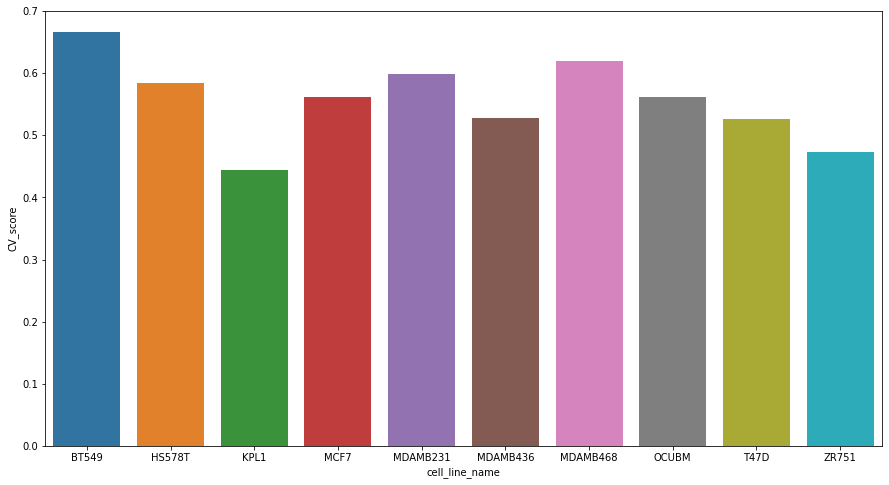

In [ ]:
CV_LCO_score = [hist_LCO_validation[i][29] for i in range(10)]
index_cell_line_out_final = index_cell_line_out
index_cell_line_out_final["CV_score"] = CV_LCO_score
plt.figure(figsize=(15,8))
sns.barplot(x="cell_line_name", y="CV_score",
            data=index_cell_line_out_final )


### Leave-drug-combination out

In [ ]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
hist_LDCO_train = []
hist_LDCO_validation = []
optimal_hyperparameter = res_mol_pickle[1]



index_leave_drug_out = drug_structure_1
syn_score = np.array(index_dataframe_df.iloc[:,3])
groups = index_df_cv_final_sorted.iloc[:,4]
gss = GroupShuffleSplit(n_splits=4, test_size=0.2, random_state=123)

for train_index, test_index in gss.split(drug_structure_1, syn_score, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    Drug_1_train, Drug_1_test = drug_structure_1[train_index], drug_structure_1[test_index]
    Drug_2_train, Drug_2_test = drug_structure_2[train_index], drug_structure_2[test_index]
    Target_protein_train,Target_protein_test = target_protein_feature[train_index],target_protein_feature[test_index]
    Cell_line_feature_train, Cell_line_feature_test = cell_line_feature[train_index],cell_line_feature[test_index]
    Synergy_score_train, Synergy_score_test =  syn_score[train_index],syn_score[test_index]
    
    my_model_fig = my_model(optimal_hyperparameter.get("layer_1"),optimal_hyperparameter.get("dropout_1"),optimal_hyperparameter.get("activation_1"),
               optimal_hyperparameter.get("layer_2"),optimal_hyperparameter.get("dropout_2"),optimal_hyperparameter.get("activation_2"),
               optimal_hyperparameter.get("optimizer_algorithm"),optimal_hyperparameter.get("lr"))

    model =my_model_fig

    hist = model.fit([Drug_1_train,Drug_2_train,Target_protein_train,Cell_line_feature_train],Synergy_score_train,
                     validation_data=([Drug_1_test,Drug_2_test,Target_protein_test,Cell_line_feature_test],Synergy_score_test),
                     epochs=optimal_hyperparameter.get("epochs"),batch_size=optimal_hyperparameter.get("batch_size"))
    
    hist_LDCO_train.append(hist.history["correlation"])
    hist_LDCO_validation.append(hist.history["val_correlation"]) 

In [ ]:
[hist_LDCO_validation[i][29] for i in range(4)]

[0.6779685616493225,
 0.7190161943435669,
 0.7049174308776855,
 0.7072186470031738]

In [ ]:
np.mean([hist_LDCO_validation[i][29] for i in range(4)])

0.7022802084684372